In [1]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


# 1. 데이터 전처리 및 로더 생성
class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        for root, _, files in os.walk(root_folder):
            for file in files:
                if file.endswith(".bin"):
                    bin_path = os.path.join(root, file)
                    json_path = bin_path.replace(".bin", ".json")

                    try:
                        # BIN 파일 읽기 (120x160 이미지)
                        bin_data = np.load(bin_path, allow_pickle=True).astype(np.float32)
                        bin_data = bin_data.reshape((120, 160))
                    except (UnicodeDecodeError, ValueError):
                        print(f"[Error] BIN 파일 읽기 실패: {bin_path}")
                        continue

                    # JSON 파일에서 state 값 읽기
                    if os.path.exists(json_path):
                        with open(json_path, "r", encoding="utf-8") as json_file:
                            json_data = json.load(json_file)
                            state = json_data.get("annotations", [{}])[0].get("tagging", [{}])[0].get("state", "N/A")
                    else:
                        print(f"[Warning] JSON 파일을 찾을 수 없습니다: {json_path}")
                        continue

                    self.data.append(bin_data)
                    self.labels.append(state)

        # Label Encoding
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

        print(f"폴더: {root_folder}, 데이터 개수: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        # PyTorch 텐서 변환 및 채널 추가
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # (1, 120, 160)
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


def load_data(data_folder, batch_size=32):
    train_dataset = CustomDataset(os.path.join(data_folder, "train"))
    val_dataset = CustomDataset(os.path.join(data_folder, "val"))
    test_dataset = CustomDataset(os.path.join(data_folder, "test"))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# 2. 모델 정의
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate=0.5):
        super().__init__()
        self.vit = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=depth,
            batch_first=True,
            dropout=dropout_rate  # Transformer 내부 드롭아웃 적용
        )
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))
        self.dropout = nn.Dropout(p=dropout_rate)  # 추가 드롭아웃 레이어

    def forward(self, x):
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # [batch_size, num_patches, embed_dim]
        x = patches + self.pos_embedding
        x = self.vit(x, x)  # [batch_size, num_patches, embed_dim]
        x = self.dropout(x.mean(dim=1))  # 드롭아웃 적용
        return x  # [batch_size, embed_dim]


class ViTClassifier(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, num_classes, dropout_rate=0.5):
        super(ViTClassifier, self).__init__()
        self.feature_extractor = ViTFeatureExtractor(
            img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate  # 전달
        )
        self.dropout = nn.Dropout(p=dropout_rate)  # Classifier 레이어에도 드롭아웃 추가
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x


# 3. 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        if scheduler is not None:
            scheduler.step()

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, "
              f"Val Accuracy: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, val_accuracies


# 4. 테스트 함수
def test_model(model, test_loader):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return test_loss / len(test_loader), test_accuracy


# 5. 실행
if __name__ == "__main__":
    data_folder = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV"
    batch_size = 16
    train_loader, val_loader, test_loader = load_data(data_folder, batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = ViTClassifier(
        img_dim_h=120, img_dim_w=160, patch_size=16, embed_dim=128,
        num_heads=4, depth=8, num_classes=4, dropout_rate=0.2
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

    num_epochs = 30
    train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
    )

    test_model(model, test_loader)


폴더: C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV\train, 데이터 개수: 35375
폴더: C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV\val, 데이터 개수: 5052
폴더: C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV\test, 데이터 개수: 5052
Using device: cuda
Epoch 1/30, Train Loss: 0.6063, Val Loss: 2.0877, Val Accuracy: 54.55%
Epoch 2/30, Train Loss: 0.5265, Val Loss: 1.8640, Val Accuracy: 59.01%
Epoch 3/30, Train Loss: 0.5422, Val Loss: 1.5216, Val Accuracy: 65.91%
Epoch 4/30, Train Loss: 0.4856, Val Loss: 1.3996, Val Accuracy: 69.14%
Epoch 5/30, Train Loss: 0.4728, Val Loss: 1.7008, Val Accuracy: 66.65%
Epoch 6/30, Train Loss: 0.4334, Val Loss: 1.7246, Val Accuracy: 67.18%
Epoch 7/30, Train Loss: 0.4237, Val Loss: 2.0633, Val Accuracy: 64.94%
Epoch 8/30, Train Loss: 0.4300, Val Loss: 1.9222, Val Accuracy: 67.04%
Epoch 9/30, Train Loss: 0.4295, Val Loss: 2.0269, Val Accuracy: 66.15%
Epoch 10/30, Train Loss: 0.4249, Val Loss: 1.9699, Val A

폴더: C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV\train, 데이터 개수: 35375
폴더: C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV\val, 데이터 개수: 5052
폴더: C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV\test, 데이터 개수: 5052
Using device: cuda
Epoch 1/30, Train Loss: 0.5692, Val Loss: 1.5499, Val Accuracy: 59.86%
Epoch 2/30, Train Loss: 0.4870, Val Loss: 1.5847, Val Accuracy: 60.43%
Epoch 3/30, Train Loss: 0.4626, Val Loss: 1.8631, Val Accuracy: 61.18%
Epoch 4/30, Train Loss: 0.4578, Val Loss: 1.6939, Val Accuracy: 59.16%
Epoch 5/30, Train Loss: 0.4392, Val Loss: 1.8795, Val Accuracy: 56.16%
Epoch 6/30, Train Loss: 0.4078, Val Loss: 2.0049, Val Accuracy: 58.69%
Epoch 7/30, Train Loss: 0.4013, Val Loss: 1.8121, Val Accuracy: 57.92%
Epoch 8/30, Train Loss: 0.3971, Val Loss: 1.9878, Val Accuracy: 57.82%
Epoch 9/30, Train Loss: 0.3964, Val Loss: 2.2613, Val Accuracy: 57.07%
Epoch 10/30, Train Loss: 0.3951, Val Loss: 2.2263, Val A

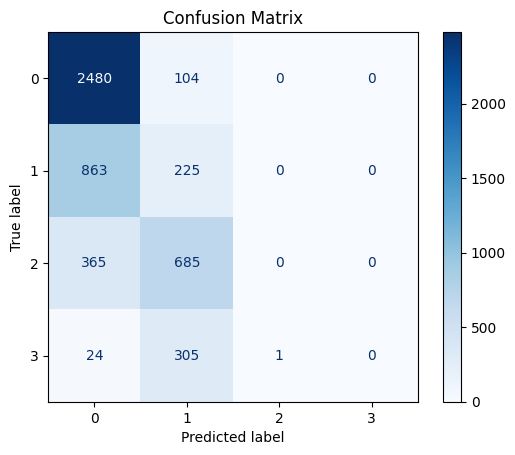

In [1]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# 1. 데이터 전처리 및 로더 생성
class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        for root, _, files in os.walk(root_folder):
            for file in files:
                if file.endswith(".bin"):
                    bin_path = os.path.join(root, file)
                    json_path = bin_path.replace(".bin", ".json")

                    try:
                        # BIN 파일 읽기 (120x160 이미지)
                        bin_data = np.load(bin_path, allow_pickle=True).astype(np.float32)
                        bin_data = bin_data.reshape((120, 160))
                    except (UnicodeDecodeError, ValueError):
                        print(f"[Error] BIN 파일 읽기 실패: {bin_path}")
                        continue

                    # JSON 파일에서 state 값 읽기
                    if os.path.exists(json_path):
                        with open(json_path, "r", encoding="utf-8") as json_file:
                            json_data = json.load(json_file)
                            state = json_data.get("annotations", [{}])[0].get("tagging", [{}])[0].get("state", "N/A")
                    else:
                        print(f"[Warning] JSON 파일을 찾을 수 없습니다: {json_path}")
                        continue

                    self.data.append(bin_data)
                    self.labels.append(state)

        # Label Encoding
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

        print(f"폴더: {root_folder}, 데이터 개수: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        # PyTorch 텐서 변환 및 채널 추가
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # (1, 120, 160)
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


def load_data(data_folder, batch_size=32):
    train_dataset = CustomDataset(os.path.join(data_folder, "train"))
    val_dataset = CustomDataset(os.path.join(data_folder, "val"))
    test_dataset = CustomDataset(os.path.join(data_folder, "test"))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# 2. 모델 정의
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate=0.5):
        super().__init__()
        self.vit = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=depth,
            batch_first=True,
            dropout=dropout_rate  # Transformer 내부 드롭아웃 적용
        )
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))
        self.dropout = nn.Dropout(p=dropout_rate)  # 추가 드롭아웃 레이어

    def forward(self, x):
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # [batch_size, num_patches, embed_dim]
        x = patches + self.pos_embedding
        x = self.vit(x, x)  # [batch_size, num_patches, embed_dim]
        x = self.dropout(x.mean(dim=1))  # 드롭아웃 적용
        return x  # [batch_size, embed_dim]


class ViTClassifier(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, num_classes, dropout_rate=0.5):
        super(ViTClassifier, self).__init__()
        self.feature_extractor = ViTFeatureExtractor(
            img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate  # 전달
        )
        self.dropout = nn.Dropout(p=dropout_rate)  # Classifier 레이어에도 드롭아웃 추가
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x


# 3. 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        if scheduler is not None:
            scheduler.step()

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, "
              f"Val Accuracy: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, val_accuracies


# 4. 테스트 함수
def test_model(model, test_loader):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Append labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    return test_loss / len(test_loader), test_accuracy


# 5. 실행
if __name__ == "__main__":
    data_folder = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV"
    batch_size = 16
    train_loader, val_loader, test_loader = load_data(data_folder, batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = ViTClassifier(
        img_dim_h=120, img_dim_w=160, patch_size=16, embed_dim=128,
        num_heads=4, depth=8, num_classes=4, dropout_rate=0.2
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

    num_epochs = 30
    train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
    )

    # Test the model and plot confusion matrix
    test_model(model, test_loader)

In [2]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


# 1. 데이터 전처리 및 로더 생성
class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        for root, _, files in os.walk(root_folder):
            for file in files:
                if file.endswith(".bin"):
                    bin_path = os.path.join(root, file)
                    json_path = bin_path.replace(".bin", ".json")

                    try:
                        # BIN 파일 읽기 (120x160 이미지)
                        bin_data = np.load(bin_path, allow_pickle=True).astype(np.float32)
                        bin_data = bin_data.reshape((120, 160))
                    except (UnicodeDecodeError, ValueError):
                        print(f"[Error] BIN 파일 읽기 실패: {bin_path}")
                        continue

                    # JSON 파일에서 state 값 읽기
                    if os.path.exists(json_path):
                        with open(json_path, "r", encoding="utf-8") as json_file:
                            json_data = json.load(json_file)
                            state = json_data.get("annotations", [{}])[0].get("tagging", [{}])[0].get("state", "N/A")
                    else:
                        print(f"[Warning] JSON 파일을 찾을 수 없습니다: {json_path}")
                        continue

                    self.data.append(bin_data)
                    self.labels.append(state)

        # Label Encoding
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

        print(f"폴더: {root_folder}, 데이터 개수: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        # PyTorch 텐서 변환 및 채널 추가
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # (1, 120, 160)
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


def load_data(data_folder, batch_size=32):
    train_dataset = CustomDataset(os.path.join(data_folder, "train"))
    val_dataset = CustomDataset(os.path.join(data_folder, "val"))
    test_dataset = CustomDataset(os.path.join(data_folder, "test"))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# 2. 모델 정의
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate=0.5):
        super().__init__()
        self.vit = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=depth,
            batch_first=True,
            dropout=dropout_rate  # Transformer 내부 드롭아웃 적용
        )
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))
        self.dropout = nn.Dropout(p=dropout_rate)  # 추가 드롭아웃 레이어

    def forward(self, x):
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # [batch_size, num_patches, embed_dim]
        x = patches + self.pos_embedding
        x = self.vit(x, x)  # [batch_size, num_patches, embed_dim]
        x = self.dropout(x.mean(dim=1))  # 드롭아웃 적용
        return x  # [batch_size, embed_dim]


class ViTClassifier(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, num_classes, dropout_rate=0.5):
        super(ViTClassifier, self).__init__()
        self.feature_extractor = ViTFeatureExtractor(
            img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate  # 전달
        )
        self.dropout = nn.Dropout(p=dropout_rate)  # Classifier 레이어에도 드롭아웃 추가
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x


# 3. 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        if scheduler is not None:
            scheduler.step()

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, "
              f"Val Accuracy: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, val_accuracies


# 4. 테스트 함수
def test_model(model, test_loader):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return test_loss / len(test_loader), test_accuracy


# 5. 실행
if __name__ == "__main__":
    data_folder = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV"
    batch_size = 16
    train_loader, val_loader, test_loader = load_data(data_folder, batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = ViTClassifier(
        img_dim_h=120, img_dim_w=160, patch_size=16, embed_dim=128,
        num_heads=4, depth=8, num_classes=4, dropout_rate=0.2
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    num_epochs = 30
    train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
    )

    test_model(model, test_loader)


폴더: C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV\train, 데이터 개수: 35375
폴더: C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV\val, 데이터 개수: 5052
폴더: C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV\test, 데이터 개수: 5052
Using device: cuda
Epoch 1/30, Train Loss: 1.1805, Val Loss: 1.1581, Val Accuracy: 53.92%
Epoch 2/30, Train Loss: 1.1730, Val Loss: 1.1584, Val Accuracy: 53.92%
Epoch 3/30, Train Loss: 1.1703, Val Loss: 1.1561, Val Accuracy: 53.92%
Epoch 4/30, Train Loss: 1.1704, Val Loss: 1.1589, Val Accuracy: 53.92%
Epoch 5/30, Train Loss: 1.1706, Val Loss: 1.1556, Val Accuracy: 53.92%
Epoch 6/30, Train Loss: 1.1688, Val Loss: 1.1540, Val Accuracy: 53.92%


KeyboardInterrupt: 